<img src="https://upskill.pt/wp-content/uploads/2020/03/cropped-APDC_UPSKILLS_Logo-300x83.png" width="200" align="center">

<h3><center>Alexandra Almeida</center></h3> 
<h1><center>Project "Green Chilli Prices in India"</center></h1>

<img src="https://www.thestatesman.com/wp-content/uploads/2019/01/Green-chillies.jpg" width="200" align="center">

#### The present project was carried out under the Machine Learning module teached by Prof. António Raimundo as part of the UpsKill program @ ISCTE - Lisbon University Institute. 

- I have select a public dataset which contains a time list of chilli peppers prices in India over 2048 days. 

- **Problem definition:** What will prices be for the next 30 days?

- The initial dataset had almost 900k rows. Every time I restarted the kernel and ran all, the data upload took a long time, so I had to reduce the data file.

- Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) were applied to predict the prices. 

## Data Wrangling: importing and cleansing data

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# import excel file and convert into pandas
df = pd.read_csv('Chillies Prices in India.csv', delimiter=';')
df.head()

,datesk,Item Name,Date,price
0,20110101,Chillies Green,01/01/2011,NaN
1,20110101,Chillies Bajji,01/01/2011,NaN
2,20110101,Chillies Cleaned,01/01/2011,NaN
3,20110101,Chillies small (C.B.P),01/01/2011,NaN
4,20110101,Chillies Bajji yagani,01/01/2011,NaN


In [3]:
# check dataframe'shape
df.shape

(13065, 4)

In [4]:
# keep green chillies data only 
df = df[(df['Item Name'] == 'Chillies Green')]
df.shape

(2613, 4)

In [5]:
#drop missing values
df.dropna(inplace=True)

In [6]:
#convert the 'Date' column into a datetime format so that it can interpreted as a date
df['Date'] = pd.to_datetime(df['datesk'], format="%Y%m%d")
df.head()

,datesk,Item Name,Date,price
339,20110309,Chillies Green,2011-03-09,30.0
340,20110310,Chillies Green,2011-03-10,30.0
360,20110314,Chillies Green,2011-03-14,30.0
370,20110316,Chillies Green,2011-03-16,30.0
378,20110317,Chillies Green,2011-03-17,30.0


In [7]:
# remove column 'datesk' and 'Item Name'
df.drop(columns = ['datesk','Item Name'], inplace=True)

In [8]:
# remove rows where price is 0
df = df[~(df['price']== 0)]
df.reset_index(drop=True, inplace=True)
df.shape

(2048, 2)

## Exploratory data analysis

In [9]:
# get the general descriptive statistics from data
df.describe()

,price
count,2048.000000
mean,35.721191
std,21.060151
min,16.000000
25%,25.000000
50%,30.000000
75%,40.000000
max,598.000000


After cleaning all columns and rows not needed, we can plot the data and visualize the prices evolution. We can see 2 data points where prices were much higher than usual.

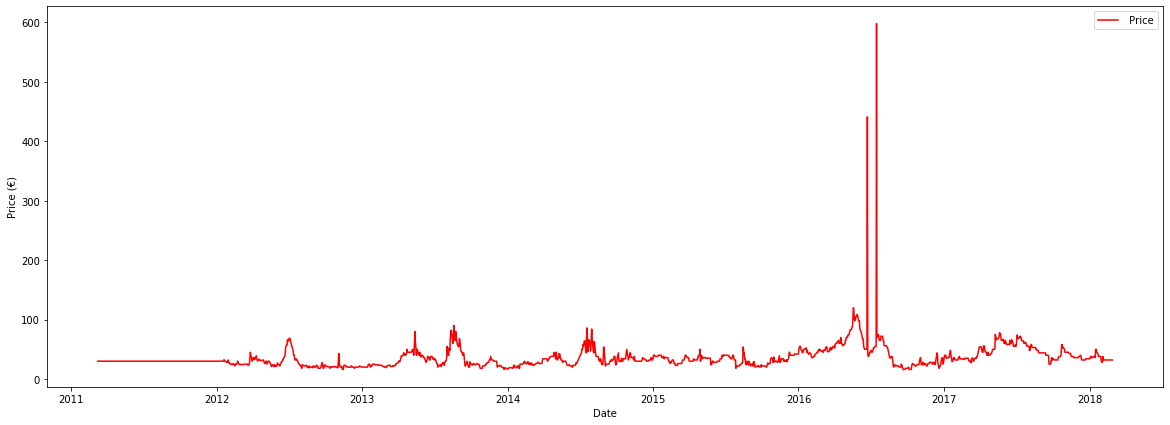

In [10]:
#sort data from older to newer prices
df.sort_values(by=['Date'], ascending = True, inplace = True)

# creating a pot in order to visualize the price evolution.
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['price'].values, label = ' Price', color = 'red')
# plt.xticks(np.arange(100,df.shape[0],100))
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

In [11]:
# sort the dataframe by descending price in order to find the 2 outlier prices
df.sort_values(by=['price'], ascending=False)

,Date,price
1592,2016-07-15,598.0
1574,2016-06-22,441.0
1544,2016-05-18,120.0
1545,2016-05-19,115.0
1551,2016-05-26,108.0
...,...,...
1649,2016-10-07,16.0
1648,2016-10-06,16.0
1638,2016-09-22,16.0
1639,2016-09-24,16.0


In [12]:
#remove prices values 598.0 and 441.0
outliers = df.index[[1574,1592]]
df.drop(outliers, inplace=True)


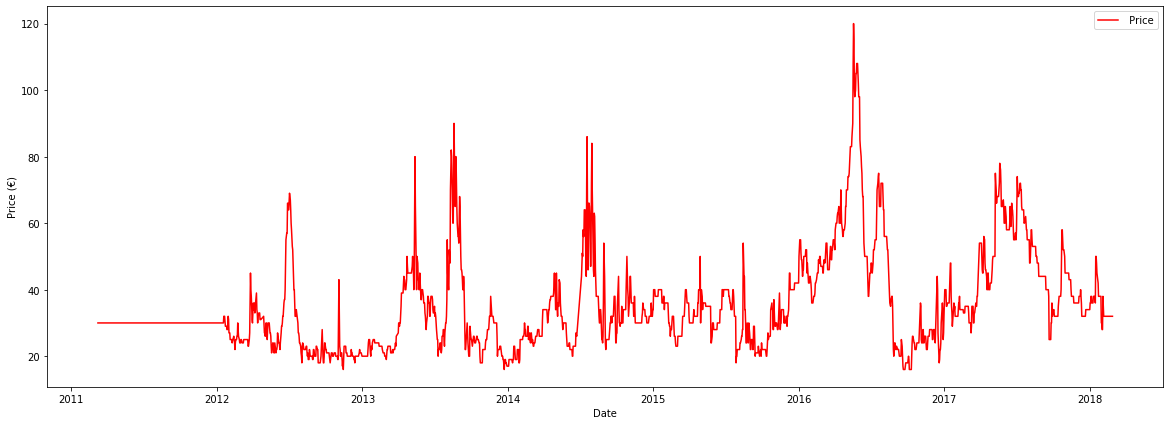

In [13]:
#Create a new plot without ouliers
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['price'].values, label = ' Price', color = 'red')
# plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## LSTM  (Long Short-Term Memory)

In [14]:
# split the ordered dataset into train and test datasets
# 80% of the number of records for training
num_records = round(len(df)*0.8)
train = df.iloc[:num_records, 1:2].values
test = df.iloc[num_records:, 1:2].values

Scaling features using normalization. 

In [15]:
# Normalize the data to avoid gradient vanishing using MinMax method 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_scaled = sc.fit_transform(train)

create a feature array, window size = 30

In [16]:
# transform train and test

X_train = []

#Price on next day
y_train = []

window = 30

for i in range(window, num_records):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
    
X_train = np.stack(X_train)
y_train = np.stack(y_train)

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Training the model.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *

# Initializing the Recurrent Neural Network

model = Sequential()

# Fit an LSTM network to training data
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

Optimizer Adaptive Moment Estimation (Adam) nearly always works faster and more reliably reaching a global minimum when minimising the cost function in training neural nets. We are trying to minimizes the mean squared error value as we fit the model.

Larger epoch values with smaller batch size reduced the MSE error while fitting the model, but the MSE global value was higher. The images below show one of other attempts trying to get the best fit:

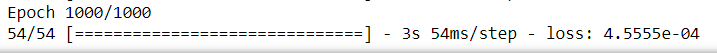

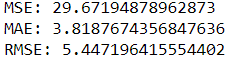

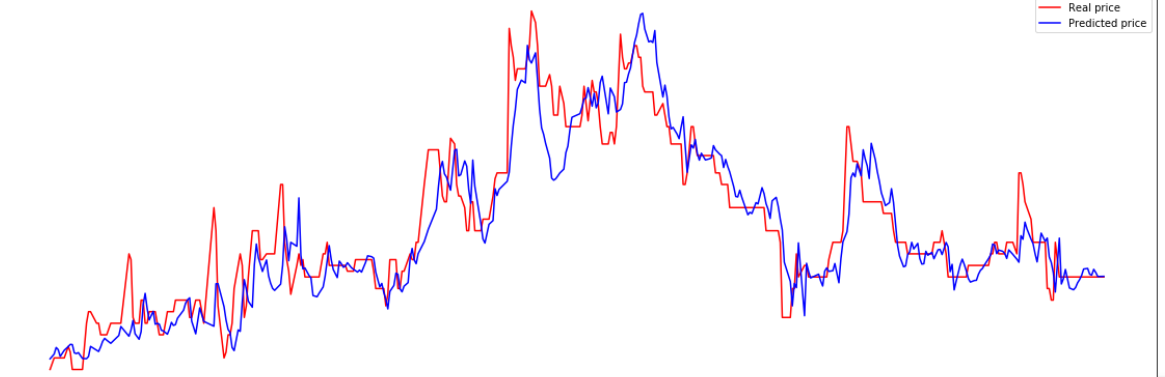

In [18]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, y_train, epochs = 500, batch_size = 512);

Epoch 1/500
4/4 [==============================] - 14s 300ms/step - loss: 0.0373
Epoch 2/500
4/4 [==============================] - 1s 316ms/step - loss: 0.0168
Epoch 3/500
4/4 [==============================] - 2s 335ms/step - loss: 0.0122
Epoch 4/500
4/4 [==============================] - 1s 306ms/step - loss: 0.0134
Epoch 5/500
4/4 [==============================] - 1s 335ms/step - loss: 0.0113
Epoch 6/500
4/4 [==============================] - 1s 325ms/step - loss: 0.0108
Epoch 7/500
4/4 [==============================] - 2s 362ms/step - loss: 0.0098
Epoch 8/500
4/4 [==============================] - 1s 342ms/step - loss: 0.0099
Epoch 9/500
4/4 [==============================] - 1s 317ms/step - loss: 0.0090
Epoch 10/500
4/4 [==============================] - 2s 361ms/step - loss: 0.0081
Epoch 11/500
4/4 [==============================] - 1s 311ms/step - loss: 0.0078
Epoch 12/500
4/4 [==============================] - 1s 328ms/step - loss: 0.0072
Epoch 13/500
4/4 [==================

4/4 [==============================] - 1s 252ms/step - loss: 0.0031
Epoch 103/500
4/4 [==============================] - 1s 241ms/step - loss: 0.0029
Epoch 104/500
4/4 [==============================] - 1s 266ms/step - loss: 0.0030
Epoch 105/500
4/4 [==============================] - 1s 261ms/step - loss: 0.0028
Epoch 106/500
4/4 [==============================] - 1s 265ms/step - loss: 0.0029
Epoch 107/500
4/4 [==============================] - 1s 296ms/step - loss: 0.0026
Epoch 108/500
4/4 [==============================] - 1s 252ms/step - loss: 0.0029
Epoch 109/500
4/4 [==============================] - 1s 314ms/step - loss: 0.0030
Epoch 110/500
4/4 [==============================] - 1s 259ms/step - loss: 0.0029
Epoch 111/500
4/4 [==============================] - 1s 272ms/step - loss: 0.0031
Epoch 112/500
4/4 [==============================] - 1s 315ms/step - loss: 0.0029
Epoch 113/500
4/4 [==============================] - 1s 297ms/step - loss: 0.0028
Epoch 114/500
4/4 [===========

4/4 [==============================] - 1s 308ms/step - loss: 0.0025
Epoch 203/500
4/4 [==============================] - 1s 277ms/step - loss: 0.0023
Epoch 204/500
4/4 [==============================] - 1s 261ms/step - loss: 0.0025
Epoch 205/500
4/4 [==============================] - 1s 274ms/step - loss: 0.0026
Epoch 206/500
4/4 [==============================] - 1s 285ms/step - loss: 0.0027
Epoch 207/500
4/4 [==============================] - 1s 253ms/step - loss: 0.0026
Epoch 208/500
4/4 [==============================] - 1s 255ms/step - loss: 0.0025
Epoch 209/500
4/4 [==============================] - 1s 257ms/step - loss: 0.0023
Epoch 210/500
4/4 [==============================] - 1s 259ms/step - loss: 0.0027
Epoch 211/500
4/4 [==============================] - 1s 264ms/step - loss: 0.0022
Epoch 212/500
4/4 [==============================] - 1s 290ms/step - loss: 0.0026
Epoch 213/500
4/4 [==============================] - 1s 297ms/step - loss: 0.0024
Epoch 214/500
4/4 [===========

4/4 [==============================] - 1s 300ms/step - loss: 0.0020
Epoch 303/500
4/4 [==============================] - 1s 321ms/step - loss: 0.0020
Epoch 304/500
4/4 [==============================] - 1s 275ms/step - loss: 0.0019
Epoch 305/500
4/4 [==============================] - 1s 267ms/step - loss: 0.0019
Epoch 306/500
4/4 [==============================] - 1s 281ms/step - loss: 0.0017
Epoch 307/500
4/4 [==============================] - 1s 339ms/step - loss: 0.0020
Epoch 308/500
4/4 [==============================] - 1s 274ms/step - loss: 0.0020
Epoch 309/500
4/4 [==============================] - 1s 237ms/step - loss: 0.0019
Epoch 310/500
4/4 [==============================] - 1s 249ms/step - loss: 0.0020
Epoch 311/500
4/4 [==============================] - 1s 280ms/step - loss: 0.0020
Epoch 312/500
4/4 [==============================] - 1s 324ms/step - loss: 0.0018
Epoch 313/500
4/4 [==============================] - 1s 259ms/step - loss: 0.0019
Epoch 314/500
4/4 [===========

4/4 [==============================] - 1s 264ms/step - loss: 0.0016
Epoch 403/500
4/4 [==============================] - 1s 314ms/step - loss: 0.0016
Epoch 404/500
4/4 [==============================] - 1s 278ms/step - loss: 0.0015
Epoch 405/500
4/4 [==============================] - 1s 274ms/step - loss: 0.0016
Epoch 406/500
4/4 [==============================] - 1s 254ms/step - loss: 0.0015
Epoch 407/500
4/4 [==============================] - 1s 253ms/step - loss: 0.0015
Epoch 408/500
4/4 [==============================] - 1s 248ms/step - loss: 0.0013
Epoch 409/500
4/4 [==============================] - 1s 230ms/step - loss: 0.0014
Epoch 410/500
4/4 [==============================] - 1s 235ms/step - loss: 0.0016
Epoch 411/500
4/4 [==============================] - 1s 257ms/step - loss: 0.0017
Epoch 412/500
4/4 [==============================] - 1s 266ms/step - loss: 0.0016
Epoch 413/500
4/4 [==============================] - 1s 275ms/step - loss: 0.0017
Epoch 414/500
4/4 [===========

## Prediction

In [19]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_records + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [20]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)
len(predict)

409

In [21]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 12.65418895338797
MAE: 2.105572628217105
RMSE: 3.5572726847105733


The MSE result has been minimized enough to proceed with the prediction. Next, I have plotted the predicted vs real prices, and they are visibly close. The model may be over fitted.

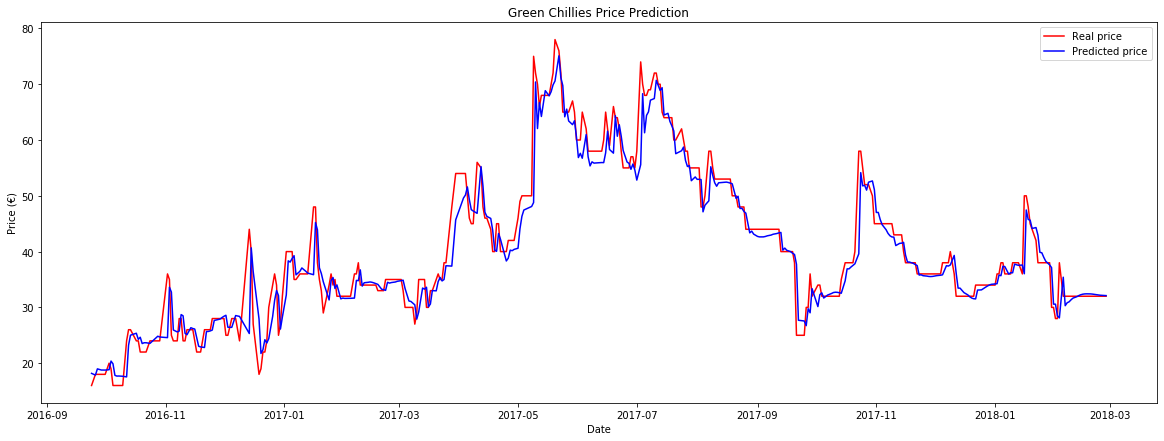

In [22]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted price')
# plt.xticks(np.arange(0,df[1800:].shape[0],25), rotation=45)
plt.title('Green Chillies Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## 30-day prediction

In [23]:
pred_ = predict[-1].copy()
prediction_full = []
window = 30
df_copy = df.iloc[:, 1:2][1:].values

for j in range(30):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_records]
    test_ = df_[num_records:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

len(prediction_full)

30

In [24]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

len(prediction_full_new)

439

In [25]:
df_date = df[['Date']]

for h in range(30):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)
len(df_date)

2076

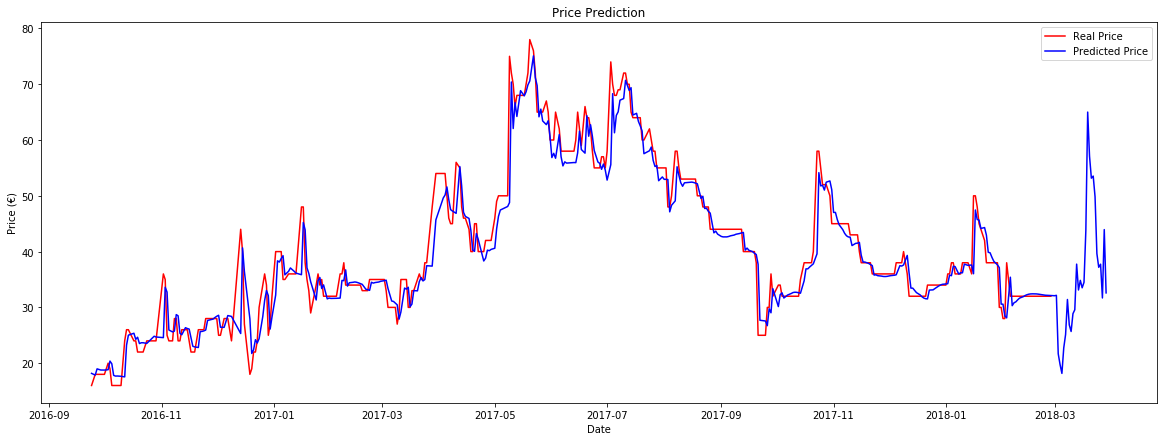

In [26]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df_date[1800:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

The first days predictions show a sudden drop in prices that may be too deep and fast, followed by a also fast and quick increase.

## GRU (Gated Recurrent Units)

In [27]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 50)            7950      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 50)            15300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 50)            15300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)               

Larger epoch values with smaller batch size reduced the MSE error while fitting the model, but the MSE global value was higher. The images below show one of other attempts trying to get the best fit:

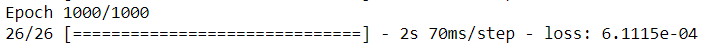
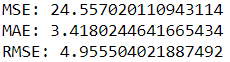
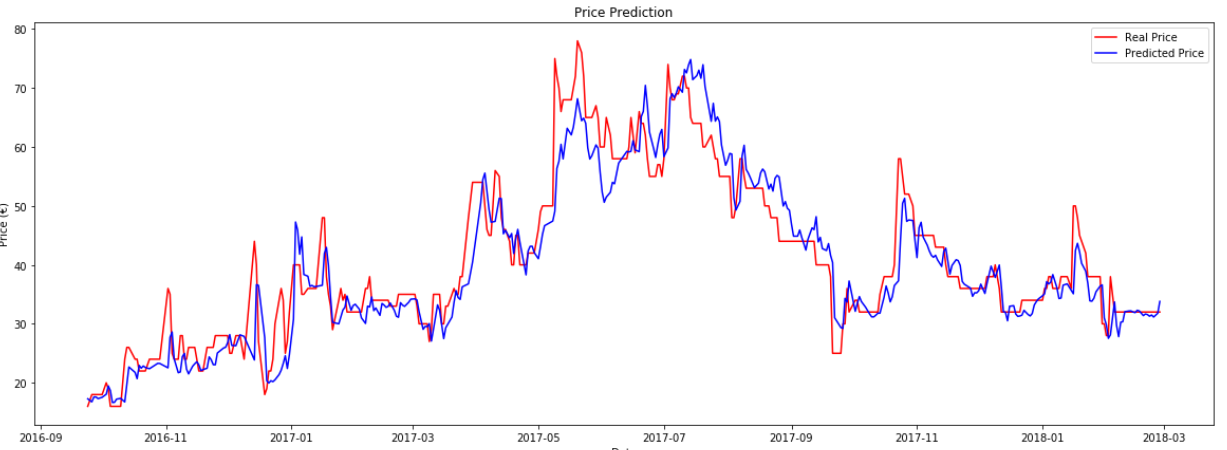

In [28]:
modelGRU.compile(optimizer='adam', loss='mse')
modelGRU.fit(X_train, y_train, epochs=500, batch_size=512)

Epoch 1/500
4/4 [==============================] - 14s 253ms/step - loss: 0.0369
Epoch 2/500
4/4 [==============================] - 1s 257ms/step - loss: 0.0123
Epoch 3/500
4/4 [==============================] - 1s 265ms/step - loss: 0.0083
Epoch 4/500
4/4 [==============================] - 1s 241ms/step - loss: 0.0083
Epoch 5/500
4/4 [==============================] - 1s 250ms/step - loss: 0.0047
Epoch 6/500
4/4 [==============================] - 1s 262ms/step - loss: 0.0051
Epoch 7/500
4/4 [==============================] - 1s 269ms/step - loss: 0.0049
Epoch 8/500
4/4 [==============================] - 1s 250ms/step - loss: 0.0041
Epoch 9/500
4/4 [==============================] - 1s 240ms/step - loss: 0.0042
Epoch 10/500
4/4 [==============================] - 1s 230ms/step - loss: 0.0040
Epoch 11/500
4/4 [==============================] - 1s 238ms/step - loss: 0.0040
Epoch 12/500
4/4 [==============================] - 1s 271ms/step - loss: 0.0037
Epoch 13/500
4/4 [==================

4/4 [==============================] - 1s 243ms/step - loss: 0.0023
Epoch 103/500
4/4 [==============================] - 1s 252ms/step - loss: 0.0020
Epoch 104/500
4/4 [==============================] - 1s 307ms/step - loss: 0.0020
Epoch 105/500
4/4 [==============================] - 1s 232ms/step - loss: 0.0019
Epoch 106/500
4/4 [==============================] - 1s 240ms/step - loss: 0.0017
Epoch 107/500
4/4 [==============================] - 1s 279ms/step - loss: 0.0019
Epoch 108/500
4/4 [==============================] - 1s 239ms/step - loss: 0.0023
Epoch 109/500
4/4 [==============================] - 1s 235ms/step - loss: 0.0019
Epoch 110/500
4/4 [==============================] - 1s 280ms/step - loss: 0.0020
Epoch 111/500
4/4 [==============================] - 1s 260ms/step - loss: 0.0019
Epoch 112/500
4/4 [==============================] - 1s 238ms/step - loss: 0.0022
Epoch 113/500
4/4 [==============================] - 1s 227ms/step - loss: 0.0020
Epoch 114/500
4/4 [===========

4/4 [==============================] - 1s 280ms/step - loss: 0.0016
Epoch 203/500
4/4 [==============================] - 1s 284ms/step - loss: 0.0017
Epoch 204/500
4/4 [==============================] - 2s 353ms/step - loss: 0.0016
Epoch 205/500
4/4 [==============================] - 1s 301ms/step - loss: 0.0018
Epoch 206/500
4/4 [==============================] - 1s 253ms/step - loss: 0.0015
Epoch 207/500
4/4 [==============================] - 1s 276ms/step - loss: 0.0016
Epoch 208/500
4/4 [==============================] - 1s 249ms/step - loss: 0.0015
Epoch 209/500
4/4 [==============================] - 1s 258ms/step - loss: 0.0017
Epoch 210/500
4/4 [==============================] - 1s 279ms/step - loss: 0.0016
Epoch 211/500
4/4 [==============================] - 1s 271ms/step - loss: 0.0016
Epoch 212/500
4/4 [==============================] - 1s 238ms/step - loss: 0.0018
Epoch 213/500
4/4 [==============================] - 1s 249ms/step - loss: 0.0016
Epoch 214/500
4/4 [===========

4/4 [==============================] - 1s 239ms/step - loss: 0.0015
Epoch 303/500
4/4 [==============================] - 1s 260ms/step - loss: 0.0016
Epoch 304/500
4/4 [==============================] - 1s 350ms/step - loss: 0.0014
Epoch 305/500
4/4 [==============================] - 1s 269ms/step - loss: 0.0016
Epoch 306/500
4/4 [==============================] - 1s 276ms/step - loss: 0.0015
Epoch 307/500
4/4 [==============================] - 1s 320ms/step - loss: 0.0016
Epoch 308/500
4/4 [==============================] - 1s 319ms/step - loss: 0.0014
Epoch 309/500
4/4 [==============================] - 1s 270ms/step - loss: 0.0016
Epoch 310/500
4/4 [==============================] - 1s 277ms/step - loss: 0.0015
Epoch 311/500
4/4 [==============================] - 1s 281ms/step - loss: 0.0017
Epoch 312/500
4/4 [==============================] - 1s 322ms/step - loss: 0.0015
Epoch 313/500
4/4 [==============================] - 1s 265ms/step - loss: 0.0015
Epoch 314/500
4/4 [===========

4/4 [==============================] - 1s 240ms/step - loss: 0.0015
Epoch 403/500
4/4 [==============================] - 1s 244ms/step - loss: 0.0015
Epoch 404/500
4/4 [==============================] - 1s 259ms/step - loss: 0.0015
Epoch 405/500
4/4 [==============================] - 1s 248ms/step - loss: 0.0016
Epoch 406/500
4/4 [==============================] - 1s 284ms/step - loss: 0.0016
Epoch 407/500
4/4 [==============================] - 1s 249ms/step - loss: 0.0015
Epoch 408/500
4/4 [==============================] - 1s 285ms/step - loss: 0.0016
Epoch 409/500
4/4 [==============================] - 1s 255ms/step - loss: 0.0015
Epoch 410/500
4/4 [==============================] - 1s 231ms/step - loss: 0.0017
Epoch 411/500
4/4 [==============================] - 1s 234ms/step - loss: 0.0017
Epoch 412/500
4/4 [==============================] - 1s 260ms/step - loss: 0.0014
Epoch 413/500
4/4 [==============================] - 1s 222ms/step - loss: 0.0014
Epoch 414/500
4/4 [===========

In [29]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [30]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 12.124752563437973
MAE: 1.9936541298490864
RMSE: 3.482061539295073


The MSE result has been minimized enough to proceed with the prediction. Next, I have plotted the predicted vs real prices, and they are visibly close. The model may be over fitted.

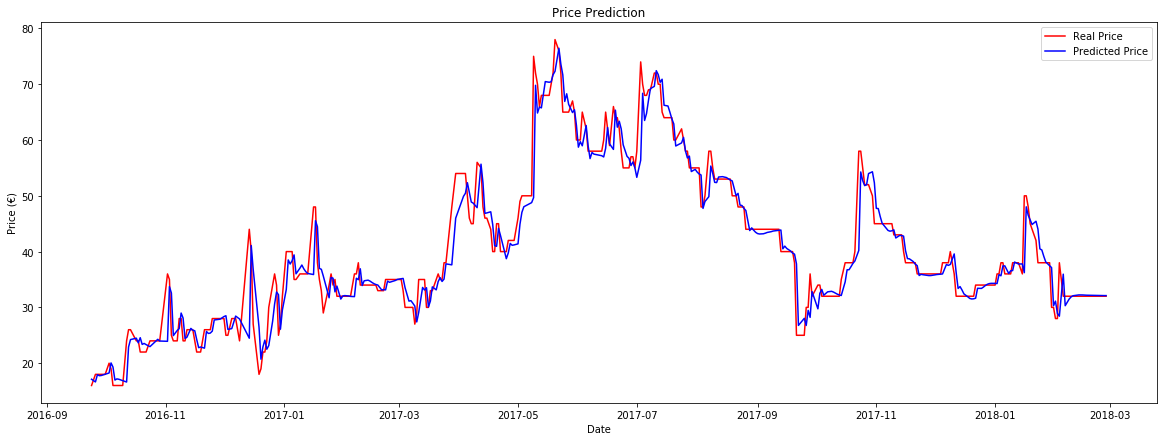

In [31]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df[num_records:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## 30-day prediction

In [32]:
pred_ = predict[-1].copy()
prediction_full = []
window = 30
df_copy = df.iloc[:, 1:2][1:].values

for j in range(30):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_records]
    test_ = df_[num_records:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [33]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(30):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

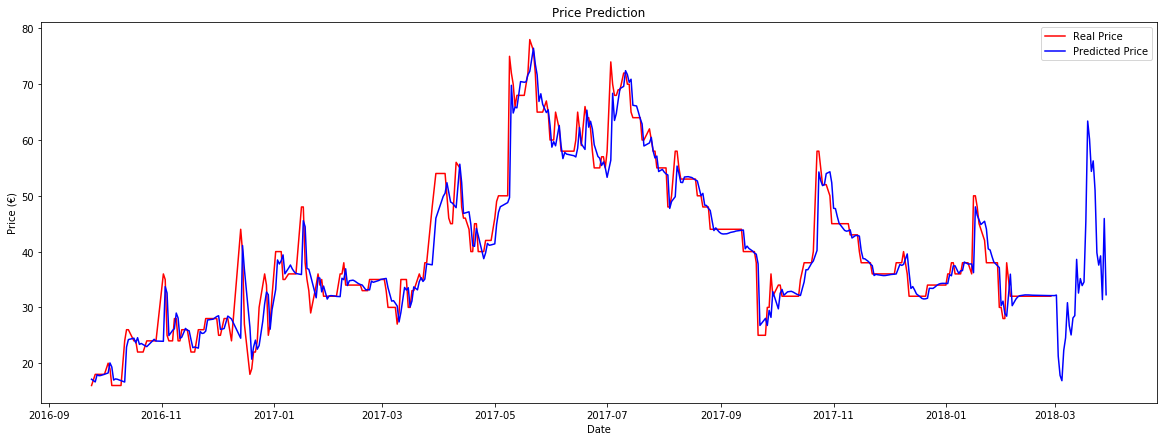

In [34]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df_date[1800:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

The first days predictions show a sudden drop in prices that may be too deep and fast, followed by a also fast and quick increase, similar to the LSTM prediction.